# This code takes input photoionization models and fits them to the observations of COS-Halos absorption systems

In [1]:
import numpy as np
import scipy.interpolate as interp
#import asciitable
from astropy.io import ascii
import xarray as xr
#import pickle as pk
import pandas as pd

print(xr.__version__,  pd.__version__)


2023.6.0 2.0.3


## Load in model

Define constants and metalicities used
Specifiy which ions to ignore (Low ions)

In [2]:
abundances = {'H':1, 'He':1/12, 'C':2.7e-4, 'N':6.7e-5, 'O':4.9e-4, 'Ne':8.5e-5, 'Mg':4.0e-5, 'Si':3.2e-5, 'S':1.3e-5 }
roman_dict = {'I':0, 'II': 1, 'III':2, 'IV':3, 'V':4, 'VI':5, 'VII':6}  #to map from indexes to array indexes;
            
    
#ignored ions 
dont_use_these_ions = ['O VI', 'H I', 'N I', 'Mg I', 'C I', 'O I', 'Si I', 'Fe I', 'Fe II', 'Fe III', 'N V']

 

RemoveBlends = 1  #removes lines that are specified as blends
min_sigma = 0.1 #minimum standard deviation allowed
max_logHI_column = 17.5  #maximum HI column density allowed
calculate_errors = 1  #calculates errors on parameters
modelstring = 'lognormal' #'lognormal'  #'mix' 'cool'   #'mixcool'
filestring = 'models_frac_eff_Z03'


if modelstring == 'lognormal':
    modeldata  = xr.open_dataset(filestring + '_wss' ,group='gr1')
    model = modeldata.equilibrium #isothermal   equilibrium isobaric adiabatic
    
    modeldata_noss  = xr.open_dataset(filestring +'_noss',group='gr1')
    model_noss = modeldata_noss.equilibrium #isothermal   equilibrium isobaric adiabatic
else:
    modeldata  = xr.open_dataset(filestring+ '_wss',group='gr2') #mixcool
    modeldata_noss  = xr.open_dataset(filestring+ '_noss',group='gr2') #mixcool
    if modelstring == 'mix':
        model = modeldata.mix_lin_fix
        model_noss = modeldata_noss.mix_lin_fix
    elif modelstring == 'cool':
        model = modeldata.cooling_fix
        model_noss = modeldata_noss.cooling_fix
    #print(modeldata.param)
    else:
        print('no such model')



narray = modeldata.n0



#for p in modeldata.param.values:
#    efrac_model = model.sel(param=p,method='nearest')
    #print([efrac_model.sel(ion='NV').values])
    #efrac_model.sel(ion='NV').values = efrac_model.sel(ion='NV').valu+1
    #efrac_model.sel(ion='NV').values=np.ones(narray.shape)
#    print([p, efrac_model.sel(ion='NV').values])

# Calculate column for a given ion

In [3]:
#takes in ion name and the total hydrogen column Nnorm
def getModelLogIonicColumn(ion_name, logNnorm, efrac_model):
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    return logNnorm + np.log10(abundances[ion_name_split[0]]*float(efrac_model.sel(ion=ion_name_nospace).values))

##  examples of how to use model

In [4]:
#specific_model = model.isel(param=2).sel(n0=0.01,method='nearest')
specific_model = model.sel(param=0.8, method='nearest').sel(n0=0.01,method='nearest') 
     #for lognormal, param is the sigma.  For other models it is the fraction in the mixing/cooling gas

#for total hydrogen column of 10^20  print some columns produced by model
print("HI column= ", getModelLogIonicColumn('H I', 20, specific_model), \
      ", CIV column= ",getModelLogIonicColumn('C IV', 20, specific_model))


HI column=  18.746017889820497 , CIV column=  12.863714268124093


# Make plot of some models

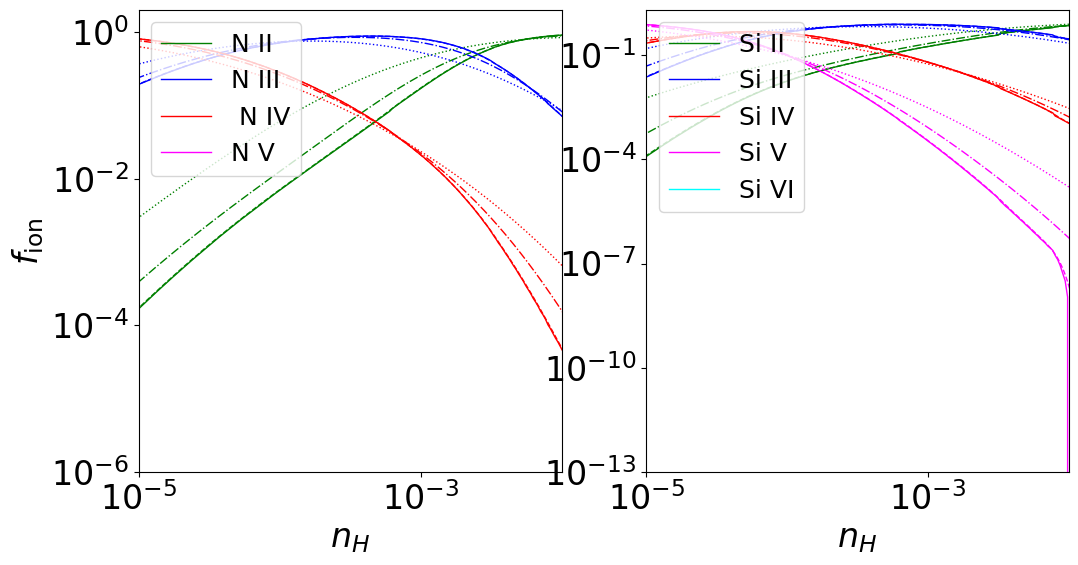

In [5]:
import matplotlib.pyplot as plt
lsarray= ['-', '--', '-.', ':']; colorarray = ['black', 'green', 'blue', 'red', 'magenta', 'cyan', 'brown']
plt.rcParams.update({'font.size': 24})
fig, (p1,p2)=plt.subplots(nrows=1, ncols=2,figsize=(12,6)) #,sharey='all')


##plot carbon
for ion_name in  ['N II', 'N III', ' N IV', 'N V']:
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    ionization_val = roman_dict[ion_name_split[1]]
    

    i=0
    for p in modeldata.param.values:
        efrac_model = model.sel(param=p,method='nearest')
        if p == 0:
            legendstring = ion_name
        else:
            legendstring = ''
        p1.loglog(narray, efrac_model.sel(ion=ion_name_nospace).values,  linestyle=lsarray[i], color=colorarray[ionization_val%7],linewidth=1, label=legendstring)
        
        i+= 1
p1.legend(loc='upper left', fontsize=18)
p1.set_xlim([10**-5, .01])
p1.set_ylim([10**-6,2])

##plot silicon
for ion_name in  ['Si II', 'Si III', 'Si IV', 'Si V', 'Si VI']:
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    ionization_val = roman_dict[ion_name_split[1]]
    
    
    i=0
    for model_sel in modeldata.param.values:
        efrac_model = model.sel(param=model_sel,method='nearest')
        if model_sel == 0:
            legendstring = ion_name
        else:
            legendstring = ''
        p2.loglog(narray, efrac_model.sel(ion=ion_name_nospace).values,  linestyle=lsarray[i], color=colorarray[ionization_val%7],linewidth=1, label=legendstring)

        i+= 1
    
p2.legend(loc='upper left', fontsize=18)
p2.set_xlim([10**-5, .01])
p2.set_ylim([10**-13,2])


p1.set_xlabel(r"$n_{H}$");p2.set_xlabel(r"$n_{H}$")
p1.set_ylabel(r"$f_{\rm ion}$")
fig.subplots_adjust(wspace=0.2)
p1.legend(loc='upper left', fontsize=18) # bbox_to_anchor=(1.12,.99),markerscale=1.5,framealpha=1,edgecolor='k')
#plt.savefig(f'./Savfig/Isochoric_coolingcolumns.png',bbox_extra_artists=(ionleg,), bbox_inches='tight')


# Read in  Cos-Halos data and output number of systems that meet criteria

In [6]:
metalprof=ascii.read('./Werk_metal_line_profile_fits.dat')
otherabs=ascii.read('./Werk_other_absorber_specs_YakovBlendIdenfication.dat')
HItablelarge = ascii.read('2017-Prochaska-apjaa6007t3_ascii.txt')
divions={}

#file to restructure the input files for our purposes
def systemdict(ID,table):
    #ID is string name of system
    # table is asciitable.read 
    """
           ----    l_logNA    Limit flag on LogNA
          [cm-2]   logNA      Log of adopted ionic column density (4)
          [cm-2]   e_logNA    Uncertainty in logNA
    """

    constraint_count = 0
    limit_count = 0
    housing={}
    for i in range(len(table)):
        if RemoveBlends:
            flag = False if table[i]['Flg'] in [3,11] else True
        else:
            flag = True
        if table[i]['ID'] == ID and flag and isinstance(table[i]['logNA'], float)==True:
            if type(table[i]['e_logNA'])==np.ma.core.MaskedConstant:
                sigma=-1
                limit_count +=1
            else:
                sigma=table[i]['e_logNA']
                if table[i]['Ion'] not in dont_use_these_ions:
                    constraint_count += 1
            #housing[table[i]['Ion'].replace(" ","")]=[table[i]['l_logNA'],table[i]['logNA'],sigma]
            housing[table[i]['Ion']]=[table[i]['l_logNA'],table[i]['logNA'],sigma, ID]
            
             
    return [housing, constraint_count, limit_count]


HItable = [[HItablelarge[:][i][0].split()[0], HItablelarge[:][i][0].split()[4]] for i in range(30)]
HItable  = (np.array(HItable)).reshape((30,2))
#print(HItable[:, 0])
#print(metalprof[:]['ID'])

numberofsystems = 0
numbofconstraints = 3
allwerksystems = []
constraint_array = []
ids_noduplicates = [i for n, i in enumerate(metalprof[:]['ID']) if i not in metalprof[:n]['ID']] 
logHI_column = 0
corrected = 0  #when this block is run, corrections then need to be applied (but not twice)

for i in range(len(ids_noduplicates)):
    #print(ids_noduplicates)
    housing, constraint_count, limit_count = systemdict(ids_noduplicates[i],otherabs)
    #print(ids_noduplicates[i], " # constraints = ", constraint_count)
    #galstring == HItable[:][jj][0].split()[0]
    
    # only if in prochaska do we use
    if ids_noduplicates[i] in HItable[:, 0]:
        index = np.where(ids_noduplicates[i] == HItable[:, 0])[0]
        logHI_column = float(HItable[index, 1][0])
        #print("Yes, contains", ids_noduplicates[i], logHI_column )
    #else:
    #print("No it doesn't contain", ids_noduplicates[i])
     # protab[:][jj][2].split()[0] 
    
    if constraint_count >= numbofconstraints and logHI_column < max_logHI_column:
        print(ids_noduplicates[i], " log NHI = ", logHI_column,\
              " log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta =", np.log10(1e18/25))
        allwerksystems.append(housing)
        numberofsystems +=1 
        constraint_array.append([constraint_count, limit_count])
    #if ids_noduplicates[i] == 'J1435+3604_68_12':
    #    print(housing, constraint_count)

print("number of systems with >= ", numbofconstraints, " constraints is ", numberofsystems)

J0910+1014_242_34  log NHI =  16.63  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1016+4706_274_6  log NHI =  17.11  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1233+4758_94_38  log NHI =  16.78  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1241+5721_208_27  log NHI =  15.35  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1322+4645_349_11  log NHI =  17.17  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1330+2813_289_28  log NHI =  17.14  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1550+4001_197_23  log NHI =  16.52  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J1555+3628_88_11  log NHI =  17.36  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.602059991327963
J2345-0059_356_12  log NHI =  17.36  log NHI_ss_HeLium =  log simga_HeII/sigma_HI*1e18/eta = 16.60205999132

# Make corrections to the systems based on our analysis

In [7]:

if corrected == 0:
    ss_flag = {}
    for Nsyst in allwerksystems:
        print(Nsyst['H I'][-1] )
        ss_flag[Nsyst['H I'][-1]] = False
        if  Nsyst['H I'][-1] == 'J0910+1014_242_34':
            print(Nsyst['H I'][-1], " CIII before = ", Nsyst['C III'][1]),
            Nsyst['C III'][1] =  13.89 #np.log10(10**Nsyst['C III'][1]- 10**13.49 - 10**13.34)
            #Nsyst['C III'][0] =  ''; Nsyst['C III'][2] = 0.9
            
            print(Nsyst['H I'][-1], "CIII after = ", Nsyst['C III'][1])
            print(Nsyst['C II'][0])
        #if  Nsyst['H I'][-1] == 'J1016+4706_274_6':
            #print(Nsyst['H I'][-1], "waiting for resolution of adding issue before I subtract"),
            #Nsyst['Si II'][1] =  np.log10(10**Nsyst['Si II'][1]- 10**12.63)
            #Nsyst['Si III'][1] =  np.log10(10**Nsyst['Si III'][1]- 10**12.74)
            #print(Nsyst['H I'][-1], " Si II after = ", Nsyst['Si II'][1], " Si III after = ", Nsyst['Si III'][1])
        #if  Nsyst['H I'][-1] = 'J1233+4758_94_38':   
        #if Nsyst['H I'][-1] == 'J1241+5721_208_27':
        #    ss_flag[Nsyst['H I'][-1]] = False
        if  Nsyst['H I'][-1] == 'J1322+4645_349_11':
            print(Nsyst['H I'][-1], " Si II before = ", Nsyst['Si II'][1], " Si III before = ", Nsyst['Si III'][1]),
            Nsyst['Si II'][1] =  13.37; #Nsyst['Si II'][2] = 0.15 #np.log10(10**Nsyst['Si II'][1]- 10**12.63)
            Nsyst['Si III'][1] = 13.73 #  np.log10(10**Nsyst['Si III'][1]- 10**12.74)
            Nsyst['Si III'][0] =  ''; Nsyst['Si III'][2] = 0.2
            
            print(Nsyst['H I'][-1], " Si II after = ", Nsyst['Si II'][1], " Si III after = ", Nsyst['Si III'][1])
            ss_flag[Nsyst['H I'][-1]] = True
        if  Nsyst['H I'][-1] == 'J1550+4001_197_23':
            print(Nsyst['H I'][-1], " Mg II before = ", Nsyst['Mg II'][1], " C II before = ", Nsyst['C II'][1], " C III before = ", Nsyst['C III'][1]),
            Nsyst['Mg II'][1] =  12.63 
            Nsyst['C II'][1] =  13.98 #np.log10(10**Nsyst['C II'][1]- 10**13.51)
            #Nsyst['C III'][1] =  14.91 #np.log10(10**Nsyst['C III'][1]- 10**12.88)
            #Nsyst['C III'][0] =  ''; Nsyst['C III'][2]=0.9
            
            print(Nsyst['H I'][-1], " Mg II after = ", Nsyst['Mg II'][1], " C II after = ", Nsyst['C II'][1], "C III after = ", Nsyst['C III'][1])
        if  Nsyst['H I'][-1] == 'J1555+3628_88_11':
            ss_flag[Nsyst['H I'][-1]] = True
        #if Nsyst['H I'][-1] == 'J2345-0059_356_12':
        #    ss_flag[Nsyst['H I'][-1]] = False

    corrected = 1
    #N_observed_dict_[ion][1]
print(ss_flag)

J0910+1014_242_34
J0910+1014_242_34  CIII before =  13.84
J0910+1014_242_34 CIII after =  13.89
--
J1016+4706_274_6
J1233+4758_94_38
J1241+5721_208_27
J1322+4645_349_11
J1322+4645_349_11  Si II before =  13.41  Si III before =  13.65
J1322+4645_349_11  Si II after =  13.37  Si III after =  13.73
J1330+2813_289_28
J1550+4001_197_23
J1550+4001_197_23  Mg II before =  12.71  C II before =  14.05  C III before =  14.1
J1550+4001_197_23  Mg II after =  12.63  C II after =  13.98 C III after =  14.1
J1555+3628_88_11
J2345-0059_356_12
{'J0910+1014_242_34': False, 'J1016+4706_274_6': False, 'J1233+4758_94_38': False, 'J1241+5721_208_27': False, 'J1322+4645_349_11': True, 'J1330+2813_289_28': False, 'J1550+4001_197_23': False, 'J1555+3628_88_11': True, 'J2345-0059_356_12': False}


# Routines for fitting the COS-Halos data and returning best fit and chi^2 values

In [8]:
#returns chi^2 array for all nH
def chi_squared_vector(N_observed_dict_, efrac_model, nHrange, logNnorm): 
    ### chi2_contr is to calculate individual chi2 of an ion 
    
    nHlen  =  sum(nHrange.values)

    large_value =1e5
    def chi2_contr(ion_name, logNmodel,logNobs,sigma,l_logNA):
        #print(ion_name, ": ", logNobs,sigma,l_logNA)
    
        if l_logNA == '>': #observations  are upper limit
            sigvec = np.copy(logNmodel)
            epsilon = np.copy(logNmodel)
            #print(np.shape(logNobs), logNmodel)
            sigvec[logNmodel > logNobs]= large_value # model fits observations, so small contribution to chi^2
            sigvec[logNmodel < logNobs]=(min_sigma)
            epsilon[logNmodel < logNobs] -= 2*min_sigma 

        elif l_logNA == '<': #observations  are lower limit
            sigvec = np.copy(logNmodel)
            epsilon = np.copy(logNmodel)
            sigvec[logNmodel < logNobs]= large_value # model fits observations, so small contribution to chi^2
            sigvec[logNmodel > logNobs]=(min_sigma)
            epsilon[logNmodel > logNobs] += 2*min_sigma  #assumes 2 sigma
            
        else:  #observations  are constrained
            sigvec= np.max([min_sigma, sigma])
            epsilon = 0 #*sigvec 
            
        chi2_contr_eqn=((logNmodel + epsilon)-logNobs)**2 /( sigvec**2 )
        
        if np.isinf( chi2_contr_eqn[0]):
            print("chisq = ", chi2_contr_eqn, ion_name, logNmodel,logNobs,sigma,l_logNA)
        return chi2_contr_eqn
    

    
    #model_ions=list(efffrac_dict_.keys())        #create list of ions in model
    observed_ions=list(N_observed_dict_.keys())  #create list of ions in observations
    
    #print("observed_ions = ", observed_ions)
    
    comp_ions=[]
    for ion in observed_ions:
        #if ion in model_ions:
        comp_ions.append(ion)  #this ensures we are only looking at the ions that are present in our and Werk's model

        
    
    
    chisq_vec = np.zeros(nHlen)
    Nions_fit = 0;  Nions_notlimits = 0
    ion_name_list = []
    for ion in comp_ions:
        #print("ion =", ion)
        if ion in dont_use_these_ions:  #skip
            continue
        
        #convert to name that has not spaces for dictionary
        ion_name_split = ion.split()
        ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()    
            
            
        logNobs=N_observed_dict_[ion][1]
        sigma=N_observed_dict_[ion][2]
        l_logNA=N_observed_dict_[ion][0]
        

        
        
        logNHmodelarray =  logNnorm + np.log10(abundances[ion_name_split[0]]) + np.log10(efrac_model.sel(ion=ion_name_nospace).values[nHrange])
   
        #print("args= ", logNobs,sigma,l_logNA, logNHmodelarray),
        #logNHmodelarray = logNHmodel.sel(ion=ion_name_nospace).values[nHrange]
        #print("columns= ", logNHmodelarray)
        
        chisq_vec += chi2_contr(ion_name_nospace, logNHmodelarray,logNobs,sigma,l_logNA)
        
        #print("chisq_vec_min = ",  np.min(chisq_vec))
        
        Nions_fit +=1
        if l_logNA != '<' and l_logNA != '>':
            Nions_notlimits += 1 
            
        #break
        ion_name_list.append(ion)
        
    return [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list]

def findSmallestChisq(Nsyst, efrac_model, nHrange, p):
    min_chisq = 1e10
    
    #loop over total column values
    for logNtot in np.linspace(16, 22, 300):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
        newestmin = np.min(chisq_vec)
        #print("chisq = ",  np.min(chisq_vec))
        if newestmin < min_chisq:
            min_chisq = newestmin
            logNbest = logNtot
            ibest = np.argmin(chisq_vec)
            nHbest = nHrange[ibest]    

    return [min_chisq, logNbest, ibest, nHbest, ion_name_list, p]



dchisq = 2.3 #difference in chi^2 for 2D data that has 68.3% interior (assuming a Gaussian)
def findParameterErrors(Nsyst, efrac_model, nHrange, X):
    #loop over total column values
    [min_chisq, logNbest, ibest, nHbest, ion_name_list, pdummy] = X
    
    dN = -1
    for logNtot in np.linspace(logNbest, logNbest+1, 100):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
        if np.min(chisq_vec) < min_chisq + dchisq:
            #print("dN = ", logNtot, logNbest, np.min(chisq_vec),  min_chisq)
            dN = logNtot - logNbest #error on column
            
    dn = 0; #error on density
    
    return [dN, dn]



def fitSystems(nrange, allwerksystems, model,  modeldata):

    logNbest = None
    all_systems = []
    for Nsyst in allwerksystems:
        systemvaluesparameters = []
        bestfitvalues = []
        for p in modeldata.param.values:    

            efrac_model  = model.sel(param=p, method ='nearest')  #.sel(n0=0.01,method='nearest')
            nHvec =modeldata.n0[nrange].values
            nHlength  =  sum(nrange.values)


            #min_chisq, logNbest, ibest, nHbest, ion_name_list = findSmallestChisq(Nsyst, efrac_model, nrange)    
            bestfitparams = findSmallestChisq(Nsyst, efrac_model, nrange, p)    
            min_chisq, logNbest, ibest, nHbest, ion_name_list, pdummy = bestfitparams

            print(p, "minchisq =", min_chisq, nHbest, logNbest, pdummy)

            if calculate_errors:
                [dN, dn] = findParameterErrors(Nsyst, efrac_model, nrange, bestfitparams)


            print("errors =", dN, dn)


            ion_names = []
            logNmodel_values = []
            logNobs_values = []
            sigma_values = []
            limit_values = []

            for ion in ion_name_list:
                #if ion == 'N V': #never very informative
                #    continue

                # Convert to name that has no spaces for dictionary
                ion_name_split = ion.split()
                ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()

                # Get observed ion info
                logNobs = Nsyst[ion][1]
                if Nsyst[ion][2] > 0:
                    sigma = max(min_sigma, Nsyst[ion][2])
                else:
                    sigma =  Nsyst[ion][2]
                l_logNA = Nsyst[ion][0]

                efrac_vec = efrac_model.sel(ion=ion_name_nospace).values[nrange]
                logNmodel = logNbest + np.log10(abundances[ion_name_split[0]]) + np.log10(efrac_vec[ibest])

                # Append values to the arrays
                ion_names.append(ion)
                logNmodel_values.append(logNmodel)
                logNobs_values.append(logNobs)
                sigma_values.append(sigma)
                limit_values.append(l_logNA)

                print(ion, "model vs observed = ", logNmodel, logNobs, sigma, l_logNA)

            systemvaluesparameters.append([ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values])
            bestfitvalues.append(bestfitparams)
            
            #print("best fit params = ", bestfitparams)

        all_systems.append([bestfitvalues, systemvaluesparameters])
        
    return all_systems

    

# This generates the fits (takes some time)

In [9]:
nrange = np.logical_and(narray> 1e-5, narray< 1e-1)

#self sheilding fits
all_systems = fitSystems(nrange, allwerksystems, model, modeldata)

#fits that aren't self shielding
all_systems_noss = fitSystems(nrange,  allwerksystems, model_noss, modeldata_noss)    

0.0 minchisq = 15.785195113946381 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.0006284 18.16722408026756 0.0
errors = 0.18181818181818343 0
C II model vs observed =  14.164500598325827 14.08 0.13 --
C III model vs observed =  14.39720049464919 13.89 -1 >
N II model vs observed =  13.764398979740553 14.17 0.12 --
Mg II model vs observed =  13.207179974750645 13.01 0.1 --
Si II model vs observed =  13.249137801896552 13.22 0.13 --
Si IV model vs observed =  11.761955228786906 12.98 -1 <
S II model vs observed =  12.784698840211904 14.82 -1 <
0.1 minchisq = 16.061803378924996 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.0006035 18.187290969899664 0.1
errors = 0.17171717171717304 0
C II model vs observed =  14.176914671025553 14.08 0.13 --
C III model vs observed =  14.421433552962982 13.89 -1 >
N II model vs observed =  13.773750029232689 14.17 0.12 --
Mg II model vs observed =  13.220751974139587 13.01 0.1 --
Si II model vs obse

errors = 0.0 0
C II model vs observed =  12.870341662862899 13.43 -1 <
N II model vs observed =  12.085702939698468 13.58 -1 <
N III model vs observed =  13.509393959316647 13.51 -1 <
Mg II model vs observed =  11.894217978099245 12.32 -1 <
Si II model vs observed =  12.045878728268697 12.84 0.1 --
Si III model vs observed =  13.104984103757738 12.72 0.1 --
Si IV model vs observed =  12.580554290134376 13.28 0.11 --
S II model vs observed =  11.408561478635912 14.26 -1 <
0.6 minchisq = 104.24710258391714 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 6.543e-05 17.745819397993312 0.6
errors = 0.010101010101010388 0
C II model vs observed =  13.0483956959715 13.43 -1 <
N II model vs observed =  12.384013585815408 13.58 -1 <
N III model vs observed =  13.49914379774134 13.51 -1 <
Mg II model vs observed =  12.069511575977632 12.32 -1 <
Si II model vs observed =  12.198718728993638 12.84 0.1 --
Si III model vs observed =  13.105461967518472 12.72 0.1 --
Si IV mode

errors = 0.11111111111111072 0
C II model vs observed =  13.650537030620491 13.98 0.12 --
C III model vs observed =  14.598026896552058 14.1 -1 >
N II model vs observed =  12.984969190050133 13.61 -1 <
N III model vs observed =  13.993024749576554 14.25 0.11 --
Mg II model vs observed =  12.665359770891408 12.63 0.1 --
Si II model vs observed =  12.794904520059 12.81 -1 <
Si III model vs observed =  13.619890009523106 13.39 0.1 --
S II model vs observed =  12.223499008747721 14.64 -1 <
S III model vs observed =  13.263156168861904 14.16 -1 <
0.6 minchisq = 17.70312548953447 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 8.682e-05 18.247491638795985 0.6
errors = 0.10101010101010033 0
C II model vs observed =  13.66564289129868 13.98 0.12 --
C III model vs observed =  14.610384176961453 14.1 -1 >
N II model vs observed =  13.049640089117563 13.61 -1 <
N III model vs observed =  13.997744610955168 14.25 0.11 --
Mg II model vs observed =  12.68604286690098 12.63 0

1.2 minchisq = 11.510874621964529 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.0001947 18.387959866220736 1.2
errors = 0.030303030303031164 0
C II model vs observed =  14.28763138849675 14.08 0.13 --
C III model vs observed =  14.621063074135833 13.89 -1 >
N II model vs observed =  13.824716406847594 14.17 0.12 --
Mg II model vs observed =  13.049178182361285 13.01 0.1 --
Si II model vs observed =  13.314393574051 13.22 0.13 --
Si IV model vs observed =  12.975761549474665 12.98 -1 <
S II model vs observed =  12.895548951466024 14.82 -1 <
0.0 minchisq = 17.976086521607353 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.0004932 19.010033444816052 0.0
errors = 0.0 0
C II model vs observed =  14.90292594933347 14.68 0.1 --
C III model vs observed =  15.283256731379593 14.58 -1 >
N II model vs observed =  14.474645851919222 14.15 0.1 --
N III model vs observed =  14.574572431520107 14.72 0.1 --
Mg II model vs observed =  13.553754461

0.0 minchisq = 2.662847101920352 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.0003293 18.648829431438127 0.0
errors = 0.08080808080807955 0
C II model vs observed =  14.401373993325066 14.34 0.1 --
C III model vs observed =  14.960937291679528 14.34 -1 >
N II model vs observed =  13.90557808899701 14.04 -1 <
N III model vs observed =  14.3157488771369 14.37 0.1 --
Mg II model vs observed =  13.00187729549572 13.03 0.1 --
Si II model vs observed =  13.322254469151869 13.37 0.1 --
Si III model vs observed =  13.989599666183901 13.73 0.2 
Si IV model vs observed =  13.303156676263686 13.41 -1 <
S II model vs observed =  12.96831223691618 14.59 -1 <
0.1 minchisq = 2.5820843577072163 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.0003293 18.648829431438127 0.1
errors = 0.08080808080807955 0
C II model vs observed =  14.405220423829293 14.34 0.1 --
C III model vs observed =  14.959744171398947 14.34 -1 >
N II model vs observed =  13.9

0.0 minchisq = 11.783152645158397 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.000269 18.94983277591973 0.0
errors = 0.09090909090908994 0
C II model vs observed =  14.62782134054457 14.49 0.1 --
C III model vs observed =  15.273380560222474 14.3 -1 >
N II model vs observed =  14.091679963474393 14.3 0.1 --
N III model vs observed =  14.644965019305682 14.55 0.1 --
Mg II model vs observed =  13.207937587113904 13.26 0.1 --
Si II model vs observed =  13.543536746589648 13.41 0.1 --
Si III model vs observed =  14.278868733811782 13.53 -1 >
Si IV model vs observed =  13.68695787613222 13.88 0.12 --
S II model vs observed =  13.185235711425396 14.66 -1 <
0.1 minchisq = 11.70379613553077 <xarray.DataArray 'n0' ()>
array(True)
Coordinates:
    n0       float64 0.000269 18.94983277591973 0.1
errors = 0.09090909090908994 0
C II model vs observed =  14.629987814394394 14.49 0.1 --
C III model vs observed =  15.272925240718042 14.3 -1 >
N II model vs observed =  14.

# Makes the plots

chisq =  [8.3289397764072, 8.54043703673284, 9.619297026831266, 11.510874621964529]
chisq =  [17.976086521607353, 18.970377671244155, 14.535585786071024, 8.440734139243927]
chisq =  [7.0976493211645755, 7.679358299087221, 6.590428344751719, 5.774602186864559]
chisq =  [86.42186025514688, 86.62747448510171, 75.56102567913454, 66.49170902859461]
chisq =  [7.353310690867946, 7.366447246494167, 7.627750956811749, 8.002819353674708]
chisq =  [64.32352509800903, 64.36123609913662, 53.18922117351068, 39.506830826959714]
chisq =  [13.05597014607937, 13.445906866146478, 12.130218069923169, 9.145476070647263]
chisq =  [46.104962017748385, 46.02377989436499, 35.96426344588421, 24.8036142944872]
chisq =  [3.5445960337632476, 3.3947045075755216, 3.624159469966717, 5.174066116768273]


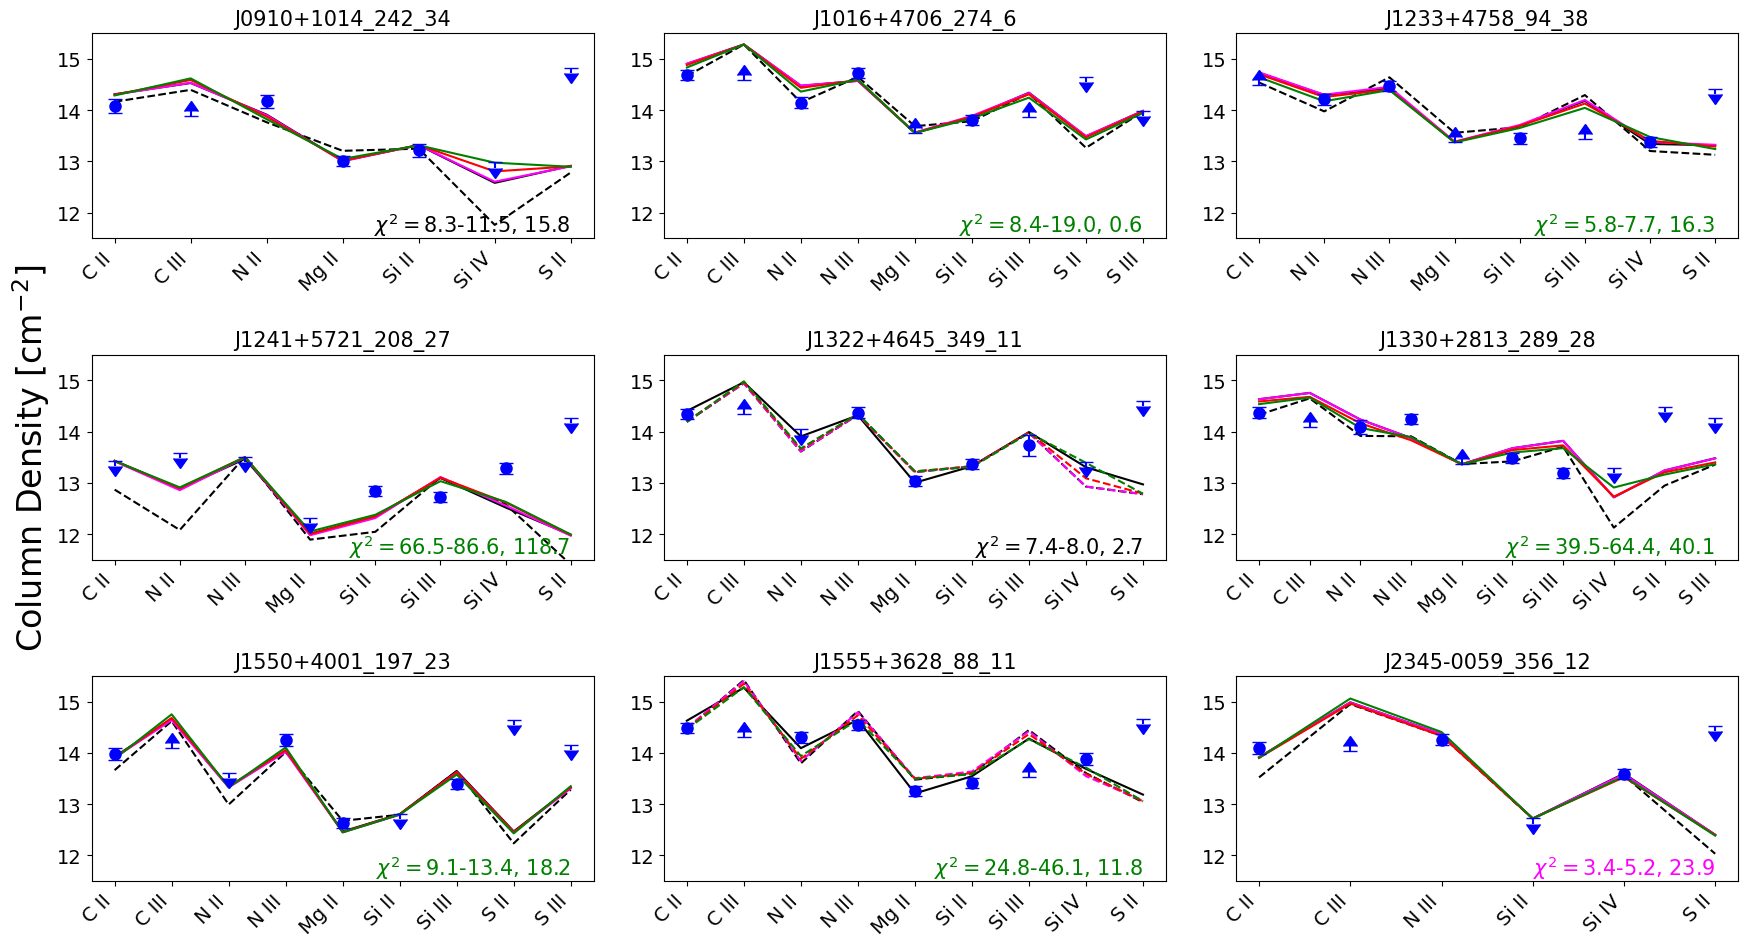

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import re


color_array = ['black', 'magenta', 'red',  'green', 'blue']

# Function to extract the Roman numeral from ion names
def extract_roman_numeral(ion_name):
    match = re.search(r'\b[IVXLCDM]+\b', ion_name)
    if match:
        return match.group()
    return ""

fig, ax = plt.subplots(nrows=len(all_systems)//3, ncols=3, figsize=(18, 10))

for isys in range(len(all_systems)):
    ix = isys//3
    iy = isys%3
    
    if ss_flag[allwerksystems[isys]['H I'][-1]] == False:
        all_systems_plot = all_systems_noss
        all_systems_other = all_systems
        default_linestyle = '-'
        other_linestyle = '--'
    else:
        all_systems_plot = all_systems
        all_systems_other = all_systems_noss
        default_linestyle = '--'
        other_linestyle = '-'
        
    # Sort data by Roman numeral
    [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][0]

    ip =0
    chisq_arr = []
    for p in modeldata.param.values: 
        if ip!=0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][ip]
            #sorted_data = sorted(zip(ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values), key=lambda x: extract_roman_numeral(x[0]))

        ax[ix, iy].plot(np.arange(len(ion_names)), logNmodel_values, linestyle=default_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
        
        if ip == 0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_other[isys][1][ip]

            ax[ix, iy].plot(np.arange(len(ion_names)), logNmodel_values, linestyle=other_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
            chisq_other = all_systems_other[isys][0][ip][0]

            
        chisq_arr.append(all_systems_plot[isys][0][ip][0])
        #print(ip, "chisq = ", all_systems_plot[isys][0][ip][0], p)
        
        ip += 1
        
        

    for i, ion in enumerate(ion_names):
        x = i
        y = logNobs_values[i]
        sigma = sigma_values[i]
        if sigma < 0:
            if limit_values[i] == '>':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, lolims=True)
            if limit_values[i] == '<':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, uplims=True)
        else:
            ax[ix, iy].errorbar(x, y, yerr=sigma, marker='o', markersize=8, color='blue', capsize=5, label=f'{ion} Observed')

        

    print("chisq = ", chisq_arr)
    
    # Set x-axis labels and tick positions
    ax[ix, iy].set_ylim(11.5, 15.5)
    ax[ix, iy].set_xticks(np.arange(len(ion_names)))
    ax[ix, iy].set_xticklabels(ion_names, rotation=45, ha='right')
    ax[ix, iy].tick_params(axis='both', labelsize=14)  
    
    system_name = allwerksystems[isys]['H I'][-1] #.replace('_', '\_')
    ax[ix,iy].set_title(system_name, fontsize=15)
    
    min_index = np.argmin(chisq_arr); max_index = np.argmax(chisq_arr)

    
    ax[ix, iy].text(len(ion_names)-1, 11.5, rf'$\chi^2= ${min(chisq_arr):.1f}-{max(chisq_arr):.1f}, {chisq_other:.1f}', \
                    ha='right', va='bottom', fontsize=15, color=color_array[min_index])


    #ax.legend()
ax[1, 0].set_ylabel('Column Density [cm$^{-2}$]')
# Show the plot
plt.tight_layout()
#plt.show()

plt.savefig(f'systemfits_{modelstring}.pdf')

# Generates table with fitted values

In [13]:
latex_output = 1 #output in latex


def SciNotation(num):
    #print("n0 = ", num)
    x='%.1e'  %num  #<-- Instead of 2, input sig here
    x= x.split('e')
    if (x[1])[0] == "-":
        return "$" +x[0]+r" \times 10^{-"+ x[1][-1] +"}$"
    else:
        return "$" + x[0]+r" \times x 10^{"+ (x[1])[-1] +"}$"

#Nsyst=allwerksystems[0] #Werkdict['_27']['_dict']

if latex_output == 0:
    print("#system constraints limits best_fit_density(sigma=0) best_fit_density(sigma=0.8) best_fit_lgNZ(sigma=0) best_fit_lgNZ(sigma=0.8) chi^2_1 chi^2_2 chi^2_3 chi^2_4  error_lgNZ(sigma=0.8) error_lgNZ(sigma=0)")


#for p in lognormal.param:
p=0
i=0
for Nsyst in allwerksystems:
    bestfit_params={}
    dN = {}; dn ={}
    for p in model.param.values: 
        #print("p =", p)
        if ss_flag[Nyst['H I'][-1]] == False:
            efrac_model  = model_noss.sel(param=p,method='nearest')
        else:
            efrac_model  = model.sel(param=p,method='nearest')
        bestfit_params[p] = findSmallestChisq(Nsyst, efrac_model, nrange, p)    # [min_chisq, logNbest, ibest, nHbest]
        #print(bestfit_params[p])
        if calculate_errors:
            [dN[p], dn[p]] = findParameterErrors(Nsyst, efrac_model, nrange, bestfit_params[p])
            #print('dN = ', dN)

    #print(Nsyst['H I'][-1], "nH = ", bestfit_params[0][3], bestfit_params[0.8][3],  " chisq = ", [bestfit_params[p][0] for p in lognormal.param.values], constraint_array[i])
    chisq = ["%.1f"%bestfit_params[p][0] for p in model.param.values]
    
    if latex_output:
        print( Nsyst['H I'][-1].replace('_', '\_') , ' &', constraint_array[i][0], '&', constraint_array[i][1], '&', SciNotation(bestfit_params[0][3]['n0'].item()),'&', SciNotation(bestfit_params[ model.param.values[-1]][3]['n0'].item()), \
          '&', float(chisq[0]),'&', float(chisq[1]),'&', float(chisq[2]),'&', float(chisq[3])), r'\\'  #, '& comments here \u005c\u005c')
    else:
        print( Nsyst['H I'][-1], constraint_array[i][0], constraint_array[i][1], bestfit_params[0][3]['n0'].item(),\
              bestfit_params[ model.param.values[-1]][3]['n0'].item(), bestfit_params[0][1], bestfit_params[0.8][1],\
              float(chisq[0]), float(chisq[1]), float(chisq[2]), float(chisq[3]),\
             dN[0], dN[0.8])
    
    i+=1
    #print(Nsyst['H I'][-1],  " chisq = ", [bestfit_params[p][-1] for p in lognormal.param.values])

NameError: name 'Nyst' is not defined

# Some notes on systems

J1241+5721_208_27: Looking at some of these J1241+5721_208_27 has high chi^2 because in part large SiIV column that all models cannot fit and so it's hard to fit this and the other lines of Si.  We fit a lower density than Jess (who finds 10^-3 and us 2x10^-4) because I think we include NV in the fit and she doesn't, and so combination of SiIV and NV.

J1016+4706_359_16: model predicts too high CII and too low Mg II.  Have not reconciled this one with Jess solution, which seems to more naturally go through these.  Might remake her plot

J1330+2813_289_28 fails very badly on CIII (by an order of magnitude).  

The property shared by two of the three high chi^2 is that the density is low enough that helium reionization matters (they are the lowest densiies)

I believe Jess is plotting 2 sigma error range